In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas
from collections import Counter

In [2]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator

import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func

In [3]:
example_prop_frame = pandas.read_csv('C:\\Users\\bonne\\BioGraph\\Examples\\Examples_prop_210216_4_individual_tile_1.csv')
#example_prop_frame = pandas.read_csv('210303_18_cut_basic.csv')

loc = example_prop_frame[(example_prop_frame.x < 1500) & 
           (example_prop_frame.y < 1500) & 
           (example_prop_frame.z > 0) & 
           (example_prop_frame.z < 50)]

descriptors = ['label', 'cell_type', 'color']
n_colors = len(loc.cell_type.unique())

In [4]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [5]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

#legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
#loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

In [6]:
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(G, 'cell_type')

for node in G.nodes:    
    nx.set_node_attributes(G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:cell_class[node]}, 'legend')

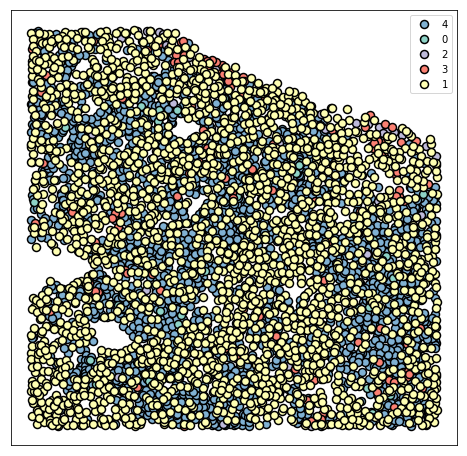

In [7]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [8]:
biograph = probability_field_hmrf_estimator.hmrf(G, epochs = 30, gamma = 0.4, K = 6)

In [9]:
biograph.initiate_latent_probability_field()

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 20113.38it/s]


In [10]:
def get_latent_probability_field_properties(G, number_of_cell_types):

    resultframe = pandas.DataFrame()
    i = 0
    
    latent_probability_field = nx.get_node_attributes(G, 'latent_probability_field')

    for node in sorted(G.nodes):
                
        for k in range(number_of_cell_types):
            resultframe.loc[i, k] = latent_probability_field[node][k]
            
        i += 1

    return resultframe.fillna(0)

In [11]:
latent_probability_field_properties = get_latent_probability_field_properties(biograph.graph, 
                                biograph.number_of_cell_types)

n_rows, n_cols = latent_probability_field_properties.shape
G = biograph.graph

X = latent_probability_field_properties.values.reshape(-1,n_cols)
X = preprocessing.StandardScaler().fit_transform(X)

In [12]:
# Apply kmeans algorithm to initiate
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

In [129]:
for node in sorted(G.nodes):
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'class')
            nx.set_node_attributes(G, {node:color_list[kmeans.labels_[node]]}, 'color')
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'legend')

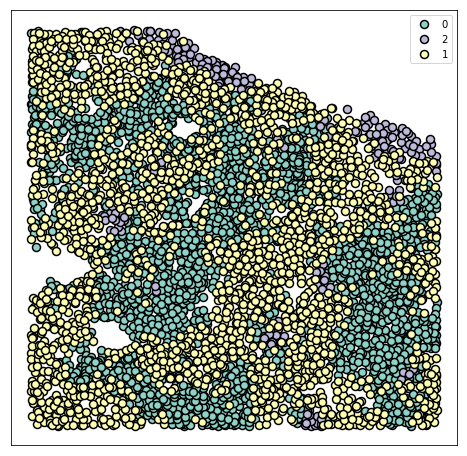

In [130]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [131]:
def categorical_vector(G, category):
    
    cat = nx.get_node_attributes(G, category)
    type_of_data = type(cat[0])
    V = np.array(list(cat.items()), dtype=type_of_data)
    a = map(int, V[:,0])
    a = np.array(list(a))
    ind = np.argsort(a)
    Vect = V[:,1][ind]
    
    return Vect

# For a categorical variable, convert vector from graph_to_numpy
# into a vector with 1 at positions for the desired value of the 
# category and 0 elsewhere

def desired_category_value(G, category, desired_value):
    
    Vect = categorical_vector(G, category)
    
    return np.multiply(Vect == desired_value, 1)

In [170]:
# initialisation
mu = []
cov = []
cl = categorical_vector(G, 'class')
ct = categorical_vector(G, 'cell_type')
for j in range(K):
    cell_type_j = ct[cl == j]
    mu.append(np.mean(cell_type_j))
    cov.append(np.cov(cell_type_j))

In [140]:
beta = 1

In [141]:
# Expectation step

cell_class_dict = nx.get_node_attributes(G, 'class')

P_neigh = np.zeros((len(G.nodes), K))

for node in tqdm(G.nodes):

    neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
    neighbour_cell_class_counter = Counter(neighbour_cell_class)

    for cell_class in neighbour_cell_class_counter.keys():
        
        for k in range(K):
            P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 34678.81it/s]


In [142]:
P_gauss = np.zeros((len(G.nodes), K))

cell_type_dict = nx.get_node_attributes(G, 'cell_type')

for node in tqdm(G.nodes):
    
    x = cell_type_dict[node]
    
    for j in range(K):
        pref = 1/np.sqrt(2*np.pi*cov[j])

        P_gauss[node, j] = pref*np.exp(-0.5*((x-mu[j])**2)/cov[j])

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 22166.06it/s]


In [147]:
# calculate product proba

prod_proba = P_gauss * P_neigh

# calculate gamma proba

gamma = np.zeros((len(G.nodes), K))

for j in range(K):
    gamma[:, j] = prod_proba[:, j]/np.sum(prod_proba,1)

In [148]:
# Maximization step
new_class = np.argmax(gamma, axis=1)

for node in sorted(G.nodes):
    nx.set_node_attributes(G, {node:new_class[node]}, 'class')
    nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:new_class[node]}, 'legend')

In [168]:
# Estimate new parameters
n = np.sum(gamma, axis = 0)

new_mu = np.dot(gamma.T, ct)/n

new_cov = np.zeros(K)
for j in range(K):
    for i in range(len(ct)):
        new_cov[j] += gamma[i, j]*((ct[i]-mu[j])**2)
new_cov /= n

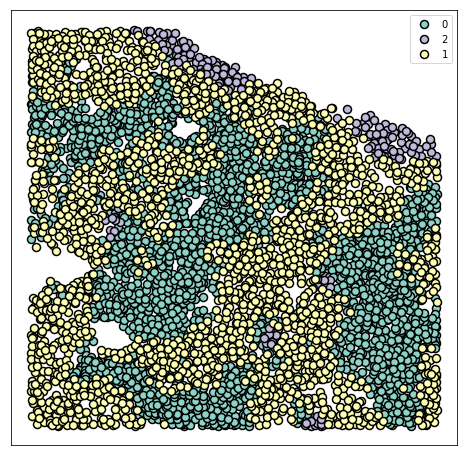

In [146]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [175]:
# Stopping criteria
stopcrit_mu = np.max(new_mu - mu)/(1 + np.max([new_mu, mu]))
stopcrit_cov = np.max(new_cov - cov)/(1 + np.max([new_cov, cov]))

In [ ]:
from 